In [1]:
import cv2
import os
import numpy as np
import shutil
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.callbacks import ModelCheckpoint
from matplotlib import pyplot as plt

Using TensorFlow backend.


### Creating Data

In [2]:
os.chdir(os.path.dirname(os.path.abspath('object_recognition.ipynb')))

In [3]:
## Delete classes from last run of script to set up the new run of the script
shutil.rmtree('./create_classes')
os.makedirs('./create_classes')

In [5]:
## Find all videos
classes = os.listdir('./input_video')
classes = [v.replace('.MOV', '') for v in classes]
classes.remove('.DS_Store')

In [6]:
## Create folders for the pictures which are extracted from every video
## Every video/folder represent one class
for i in classes: os.makedirs('./create_classes/%s' %i)

In [7]:
## Extract pictures from videos and insert them into the prepared folders.
## We end up with one folder per class, filled with pictures from the respective video
for i in classes:
    vidcap = cv2.VideoCapture('input_video/%s.MOV' %i)
    num_frames=int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))-1
    length = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    used_frames=np.unique(np.linspace(1, length, num=num_frames).astype(int))
    success,image = vidcap.read()
    if success: print(i+': Added to data')
    count = 0
    success = True
    while success:
     success,image = vidcap.read()
     if count in used_frames:
       cv2.imwrite('create_classes/'+str(i)+'/frame %s.jpg' %count, image)
     count += 1
     

Item 1: Added to data
Item 2: Added to data
Item 4: Added to data


### Create X_train and y_train

In [8]:
## We now have a folder for every class. The folders are filled with pictures from the respective videos.
## In this step we load the pictures as individual arrays into a list named X_train
## At the same time we create a list which is named y_train. Contains the labels for each picture.
## Label is taken from folder name.
X_train=list()
y_train=list()
for i in classes:
  pic_list=os.listdir('./create_classes/%s' %i)
  for pic in pic_list:
   path='./create_classes/'+i+'/'+pic
   pic=cv2.imread(path,1)
   pic=cv2.cvtColor(pic, cv2.COLOR_BGR2RGB)
   X_train.append(pic)
   y_train.append(i)

In [9]:
## Concatenating the lists into numpy arrays 
X_train=np.stack(X_train, axis=0)
y_train=np.stack(y_train, axis=0)

In [10]:
## Encode class values as integers and apply one hot encoding
## This is necessary to feed the data to keras
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
y_train = np_utils.to_categorical(encoded_Y)

In [12]:
## Create Models
num_classes = y_train.shape[1]
## num_pixels = X_train.shape[1] * X_train.shape[2]

In [13]:
## Reshape X_train to comply with keras convention
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2],3).astype('float32')

In [14]:
## Normalize inputs from 0-255 to 0-1
X_train = X_train / 255

In [15]:
## Split into test and training set
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

### Model

In [16]:
## Define model
model = Sequential()
model.add(Conv2D(30, (5, 5), input_shape=(320, 568,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(15, (3, 3), activation='relu'))
model.add(Conv2D(15, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(320, activation='relu'))
model.add(Dense(160, activation='relu'))
model.add(Dense(80, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Add checkpoint
mcp = ModelCheckpoint(filepath='best_val_acc_weights.hdf5', monitor="val_acc",save_best_only=True, save_weights_only=False)

In [17]:
## train model and save the weights of the epoch with the highest validation accuracy (important!)
history=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=50, verbose=2, callbacks=[mcp])

Train on 1250 samples, validate on 617 samples
Epoch 1/10
396s - loss: 1.5262 - acc: 0.4456 - val_loss: 0.7241 - val_acc: 0.7407
Epoch 2/10
398s - loss: 0.3470 - acc: 0.8720 - val_loss: 0.2520 - val_acc: 0.9335
Epoch 3/10
393s - loss: 0.1181 - acc: 0.9648 - val_loss: 0.0143 - val_acc: 0.9984
Epoch 4/10
395s - loss: 0.0053 - acc: 0.9992 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 5/10
386s - loss: 5.4838e-04 - acc: 1.0000 - val_loss: 3.1167e-04 - val_acc: 1.0000
Epoch 6/10
381s - loss: 1.6868e-04 - acc: 1.0000 - val_loss: 1.5605e-04 - val_acc: 1.0000
Epoch 7/10
389s - loss: 1.0852e-04 - acc: 1.0000 - val_loss: 1.1586e-04 - val_acc: 1.0000
Epoch 8/10
378s - loss: 7.4928e-05 - acc: 1.0000 - val_loss: 7.8103e-05 - val_acc: 1.0000
Epoch 9/10
382s - loss: 5.1584e-05 - acc: 1.0000 - val_loss: 6.4439e-05 - val_acc: 1.0000
Epoch 10/10
376s - loss: 4.0000e-05 - acc: 1.0000 - val_loss: 4.9232e-05 - val_acc: 1.0000


In [18]:
## Summarize model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 316, 564, 30)      2280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 158, 282, 30)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 156, 280, 15)      4065      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 154, 278, 15)      2040      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 77, 139, 15)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 77, 139, 15)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 160545)            0         
__________

In [18]:
## ONLY USE IF LAST EPOCH IS NOT YOUR PREFERRED MODEL
## load weights with heighest val_acc
model.load_weights('best_val_acc_weights.hdf5')

### Evaluate Model

In [19]:
## Baseline Model for epoch with highest val_acc
scores = model.evaluate(X_train, y_train, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Baseline Error: 0.00%


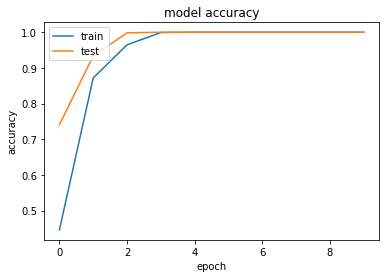

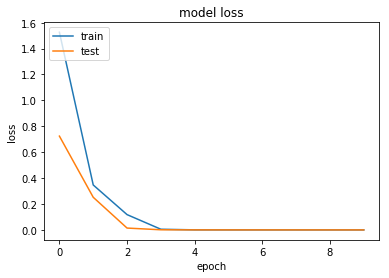

In [20]:
## http://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
## summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
## summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [31]:
## Predict on X_test
y_pred=model.predict_classes(X_test, batch_size=32, verbose=1)

617/617 [==============================] - 52s     

In [111]:
## reverse one-hot-encoding for y_test for use in confusion-matrix
x1 = np.arange(num_classes)
x2=np.multiply(y_test, x1)
y_test_no_hot=np.sum(x2,axis=1)

In [112]:
## Plot confusion matrix
confusion_matrix(y_test_no_hot,y_pred)

array([[198,   0,   0],
       [  0, 208,   0],
       [  0,   0, 211]])